In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [10]:
# # 扩展图像的函数
# def extend_image(image):
#     # 获取图像的高和宽
#     H, W, C = image.shape
#     add = 25
#     # 创建一个新的图像，大小为原图的基础上增加上下左右各10像素的边界
#     new_image = np.zeros((H + add*2, W + add*2, C), dtype=np.uint8)
    
#     # 将原图放在新图像的中心
#     new_image[add:H+add, add:W+add, :] = image

#     # # 上边界 (取第一行的像素均值作为过渡)
#     for i in range(add):
#         new_image[add-i-1, add:W+add, :] = np.mean(image[0:i+1, :, :], axis=0)
    
#     # # 下边界 (取最后一行的像素均值作为过渡)
#     for i in range(add):
#         new_image[H+add+i, add:W+add, :] = np.mean(image[H-i-1:H, :, :], axis=0)

#     # 左边界 (取第一列的像素均值作为过渡)
#     for i in range(add):
#         new_image[add:H+add, add-i-1, :] = np.mean(image[:, 0:i+1, :], axis=1)

#     # 右边界 (取最后一列的像素均值作为过渡)
#     for i in range(add):
#         new_image[add:H+add, W+add+i, :] = np.mean(image[:, W-i-1:W, :], axis=1)

#     # 处理四个角
#     for i in range(add):
#         for j in range(add):
#             # 左上角
#             new_image[add-i, add-j, :] = np.mean(image[0:i+1, 0:j+1, :])
#             # 右上角
#             new_image[add-i, W+add+j, :] = np.mean(image[0:i+1, W-j-1:W, :])
#             # 左下角
#             new_image[H+add+i, add-j, :] = np.mean(image[H-i-1:H, 0:j+1, :])
#             # 右下角
#             new_image[H+add+i, W+add+j, :] = np.mean(image[H-i-1:H, W-j-1:W, :])

#     return new_image

In [11]:
def extend_image(image):
    # Get image dimensions
    H, W, C = image.shape
    add = 25
    n = 1
    neighbor_size = int(min(H / 4, W / 4))  # Reference more neighboring pixels
    
    kernel_size_value = 65  # Must be a positive odd integer
    ksize = (kernel_size_value, kernel_size_value)
    sigma = 0  # Sigma value; 0 means it's calculated by OpenCV

    # Create a blurred version of the image
    blurred_image = cv2.GaussianBlur(image, ksize, sigma)

    # Create a new image with added borders
    new_image = np.zeros((H + add * 2, W + add * 2, C), dtype=np.uint8)

    # Place the original image in the center
    new_image[add:H + add, add:W + add, :] = image

    # Top border
    mean_row_top = np.mean(blurred_image[0:neighbor_size, :, :], axis=0)
    for i in range(add):
        w = ((add - i) / add) ** n
        edge_row_top = np.mean(image[0:i + 1, :, :], axis=0)
        new_image[add - i - 1, add:W + add, :] = (w * edge_row_top + (1 - w) * mean_row_top).astype(np.uint8)

    # Bottom border
    mean_row_bottom = np.mean(blurred_image[max(0, H - neighbor_size):H, :, :], axis=0)
    for i in range(add):
        w = ((add - i) / add) ** n
        edge_row_bottom = np.mean(image[H - i - 1:H, :, :], axis=0)
        new_image[H + add + i, add:W + add, :] = (w * edge_row_bottom + (1 - w) * mean_row_bottom).astype(np.uint8)

    # Left border
    mean_col_left = np.mean(blurred_image[:, 0:neighbor_size, :], axis=1)
    for i in range(add):
        w = ((add - i) / add) ** n
        edge_col_left = np.mean(image[:, 0:i + 1, :], axis=1)
        new_image[add:H + add, add - i - 1, :] = (w * edge_col_left + (1 - w) * mean_col_left).astype(np.uint8)

    # Right border
    mean_col_right = np.mean(blurred_image[:, max(0, W - neighbor_size):W, :], axis=1)
    for i in range(add):
        w = ((add - i) / add) ** n
        edge_col_right = np.mean(image[:, W - i - 1:W, :], axis=1)
        new_image[add:H + add, W + add + i, :] = (w * edge_col_right + (1 - w) * mean_col_right).astype(np.uint8)

    # Corners
    # Mean values for corners
    mean_pixel_top_left = np.mean(blurred_image[0:neighbor_size, 0:neighbor_size, :], axis=(0, 1))
    mean_pixel_top_right = np.mean(blurred_image[0:neighbor_size, W - neighbor_size:W, :], axis=(0, 1))
    mean_pixel_bottom_left = np.mean(blurred_image[H - neighbor_size:H, 0:neighbor_size, :], axis=(0, 1))
    mean_pixel_bottom_right = np.mean(blurred_image[H - neighbor_size:H, W - neighbor_size:W, :], axis=(0, 1))

    # Top-left corner
    for i in range(add):
        for j in range(add):
            w_row = ((add - i) / add) ** n
            w_col = ((add - j) / add) ** n
            w = w_row * w_col
            edge_pixel = np.mean(image[0:i + 1, 0:j + 1, :], axis=(0, 1))
            new_image[add - i - 1, add - j - 1, :] = (w * edge_pixel + (1 - w) * mean_pixel_top_left).astype(np.uint8)

    # Top-right corner
    for i in range(add):
        for j in range(add):
            w_row = ((add - i) / add) ** n
            w_col = (j / add) ** n
            w = w_row * (1 - w_col)
            edge_pixel = np.mean(image[0:i + 1, W - j - 1:W, :], axis=(0, 1))
            new_image[add - i - 1, W + add + j, :] = (w * edge_pixel + (1 - w) * mean_pixel_top_right).astype(np.uint8)

    # Bottom-left corner
    for i in range(add):
        for j in range(add):
            w_row = (i / add) ** n
            w_col = ((add - j) / add) ** n
            w = (1 - w_row) * w_col
            edge_pixel = np.mean(image[H - i - 1:H, 0:j + 1, :], axis=(0, 1))
            new_image[H + add + i, add - j - 1, :] = (w * edge_pixel + (1 - w) * mean_pixel_bottom_left).astype(np.uint8)

    # Bottom-right corner
    for i in range(add):
        for j in range(add):
            w_row = (i / add) ** n
            w_col = (j / add) ** n
            w = (1 - w_row) * (1 - w_col)
            edge_pixel = np.mean(image[H - i - 1:H, W - j - 1:W, :], axis=(0, 1))
            new_image[H + add + i, W + add + j, :] = (w * edge_pixel + (1 - w) * mean_pixel_bottom_right).astype(np.uint8)

    return new_image
 


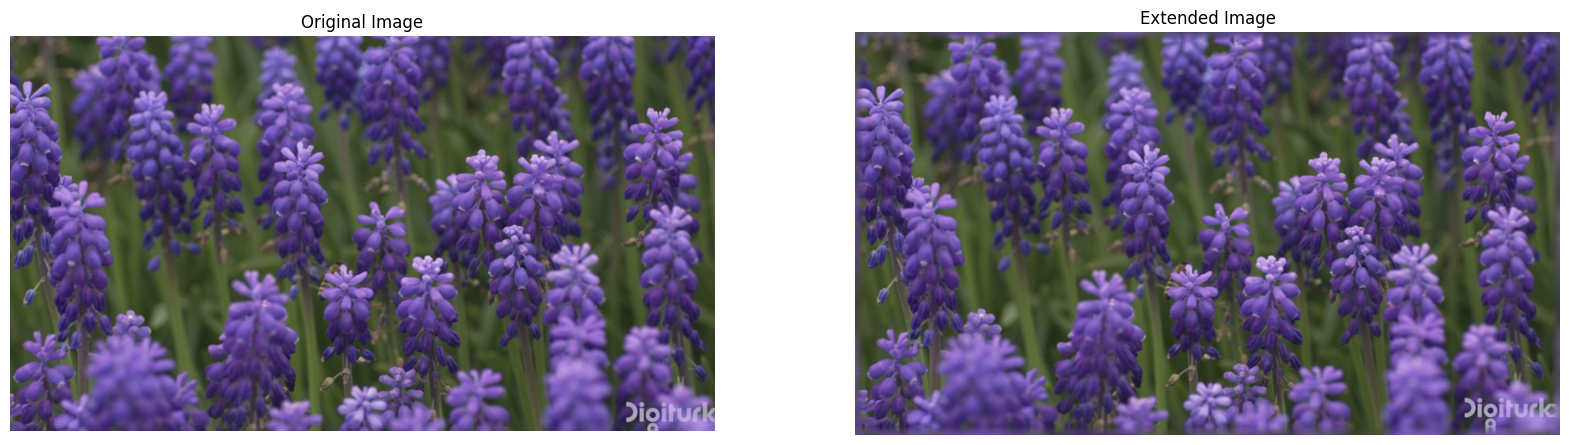

扩展后的图像已保存为 'extended_test.png'


In [12]:
# 读取图片test.png
image = cv2.imread('test.png')
add=25
# 转换为RGB格式以便matplotlib显示
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 调用extend_image函数进行扩展
extended_image = extend_image(image_rgb)
H, W, C = image_rgb.shape
# 使用matplotlib显示原始图像和扩展图像
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
# plt.imshow(extended_image[add:H+add,add:W+add,:])
plt.imshow(extended_image)
plt.title('Extended Image')
plt.axis('off')

plt.show()

# 保存扩展后的图像
extended_image_bgr = cv2.cvtColor(extended_image, cv2.COLOR_RGB2BGR)
cv2.imwrite('extended_test.png', extended_image_bgr)
print("扩展后的图像已保存为 'extended_test.png'")